# Clinical Notes Analysis – NER & Medical specialty Classification
**Author:** Maria Kalimeri  
**Domain:** Clinical Text Classification  
**Date:** October 2025

---

## 1. Introduction
In this project, I will use a dataset containing clinical notes to examine how Natural Language Processing techniques can be applied to extract diseases and medications, as well as classify patient records into medical expertise.  

**Goals:**
- Named Entity Recognition (NER)
- Entity linking with UMLS
- Medical specialty classification
- Visualisation of insights

---

First, we need to import the necessary libraries. The installation of the libraries has been performed in a dedicated conda environment (see README.md). **If the environment has not been created yet, do this before continuing!**

In [1]:
# Imports

from collections import defaultdict
from pathlib import Path
import sys
import textwrap
from wordcloud import WordCloud

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scispacy
from scispacy.linking import EntityLinker
import seaborn as sns
import spacy
from spacy import displacy
from spacy.cli import download

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Install and import scispacy models
print('Geting scispacy models')
! python -m pip install "en_ner_bc5cdr_md @ https://huggingface.co/daviibrt/en_ner_bc5cdr_md/resolve/main/en_ner_bc5cdr_md-any-py3-none-any.whl" -q
import en_ner_bc5cdr_md


Your CPU supports instructions that this binary was not compiled to use: SSE4.1 SSE4.2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib
/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Geting scispacy models
DEPRECATION: Wheel filename 'en_ner_bc5cdr_md-any-py3-none-any.whl' is not correctly normalised. Future versions of pip will raise the following error:
Invalid wheel filename (invalid version): 'en_ner_bc5cdr_md-any-py3-none-any'

 pip 25.3 will enforce this behaviour change. A possible replacement is to rename the wheel to use a correctly normalised name (this may require updating the version in the project metadata). Discussion can be found at https://github.com/pypa/pip/issues/12938


Make sure the correct versions of Python/spacy/scispacy are being used

In [2]:
# Versions installed
print("Python executable:", sys.executable)
print("spaCy version:", spacy.__version__)
print("SciSpaCy version:", scispacy.__version__)

# Validate spaCy instalation
! python -m spacy validate

Python executable: /Users/mariakalimeri/opt/anaconda3/envs/nlp_env/bin/python
spaCy version: 3.6.1
SciSpaCy version: 0.5.3
✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.6.1) =================
ℹ spaCy installation:
/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/spacy

NAME                  SPACY            VERSION                            
en_ner_bc5cdr_md      >=3.6.1,<3.7.0   0.5.3   ✔
en_core_sci_scibert   >=3.6.1,<3.7.0   0.5.3   ✔



**Note regarding the scispacy model used**

As explained in the README file, in order to use scispacy, an older version of spacy, and other libraries, needed to be used. The scispacy libraries compatible with this version of spacy are not widely available. Specifically, I was able to only use library *en_ner_bc5cdr_md* succesfully. This library's pipeline contains the following components: tok2vec, tagger, attribute_ruler, lemmatizer, parser, ner

As a result, I was able to use this library for preprocessing of the text (tokenization, lemmatization) as well as for Named Entity Recognition (NER).

## 2. Dataset

I used a dataset available in Kaggle, which contains sample medical transcriptions for various medical specialties, scrapped from mtsamples.com [1]

**TODO**: The dataset has been manually download and saved locally. Update code to download it automatically from Kaggle, if not available

In [3]:
# Get the dataset
file_path = "../data/mtsamples.csv"
transcriptionsall_df = pd.read_csv(file_path)

transcriptionsall_df.head()
transcriptionsall_df = pd.read_csv(file_path)
transcriptionsall_df.drop(columns="Unnamed: 0", inplace=True)

transcriptionsall_df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


For our purposes, we will only use columns medical_specialty and transcription, so I will remove the rest.

In [4]:
columns_to_keep = ['medical_specialty', 'transcription']

transcriptions_df = transcriptionsall_df[columns_to_keep]
transcriptions_df.head()

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


Let's print an example of the text we will process

In [5]:
line_len = 120
sample_loc = 90

print(" TEXT EXAMPLE ".center(line_len))
print("\n")
sample_txt = transcriptions_df.transcription[sample_loc]
print(textwrap.fill(sample_txt,line_len))

                                                      TEXT EXAMPLE                                                      


PREOPERATIVE DIAGNOSIS:  ,Right ureteropelvic junction obstruction.,POSTOPERATIVE DIAGNOSES:,1.  Right ureteropelvic
junction obstruction.,2.  Severe intraabdominal adhesions.,3.  Retroperitoneal fibrosis.,PROCEDURES PERFORMED:,1.
Laparoscopic lysis of adhesions.,2.  Attempted laparoscopic pyeloplasty.,3.  Open laparoscopic pyeloplasty.,ANESTHESIA:,
General.,INDICATION FOR PROCEDURE:  ,This is a 62-year-old female with a history of right ureteropelvic junction
obstruction with chronic indwelling double-J ureteral stent.  The patient presents for laparoscopic
pyeloplasty.,PROCEDURE: , After informed consent was obtained, the patient was taken to the operative suite and
administered general anesthetic.  The patient was sterilely prepped and draped in the supine fashion after building up
the right side of the OR table to aid in the patient's positioning for bowel retr

## 3. Initial Data Exploration

### Check data types, missing values

In [6]:
print(f"The dataset consists of {transcriptions_df.shape[0]} rows")

The dataset consists of 4999 rows


In [7]:
transcriptions_df.dtypes

medical_specialty    object
transcription        object
dtype: object

The data types of both columns is "object". Let's change the type of "medical_specialty" to Categorical.

In [8]:
transcriptions_df.medical_specialty = transcriptions_df.medical_specialty.astype("category")
transcriptions_df.dtypes

/var/folders/h3/nfz97p4s4nbfn9k6j6f6cknh0000gn/T/ipykernel_3082/4227329406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcriptions_df.medical_specialty = transcriptions_df.medical_specialty.astype("category")


medical_specialty    category
transcription          object
dtype: object

In [9]:
def look_for_missing_values(df):
  null_percentages = df.isna().sum() / df.shape[0] * 100
  print("Percentage of rows with null values per column\n")
  for column, percentage in null_percentages.items():
      print(f"{column}: {percentage:.2f}%")

look_for_missing_values(transcriptions_df)

Percentage of rows with null values per column

medical_specialty: 0.00%
transcription: 0.66%


We drop the rows that have null transcription.

In [10]:
transcriptions_df = transcriptions_df.dropna()

In [11]:
look_for_missing_values(transcriptions_df)

print(f"The dataset now consists of {transcriptions_df.shape[0]} rows")

Percentage of rows with null values per column

medical_specialty: 0.00%
transcription: 0.00%
The dataset now consists of 4966 rows


### Look for empty transcriptions/medical specialties

It is possible that an entry is not null, but still contains no text (empty string). Let's see if this is the case for medical specialties or transcriptions.

In [12]:
transcriptions_df['length_medical_specialty'] = transcriptions_df.medical_specialty.apply(lambda x: len(x))
transcriptions_df['length_transcription'] = transcriptions_df.transcription.apply(lambda x: len(x))


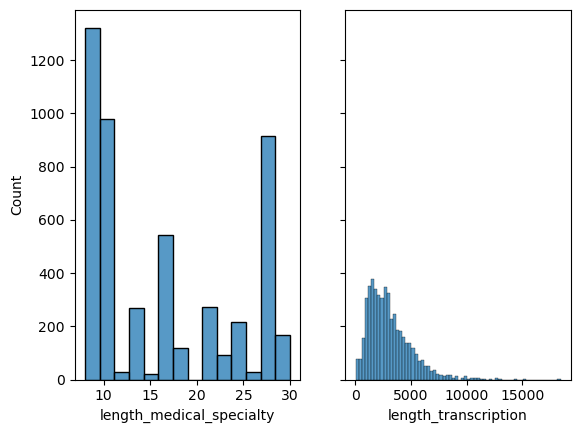

In [13]:
fig, ax = plt.subplots(1,2, sharey=True)
sns.histplot(data=transcriptions_df, x="length_medical_specialty", ax=ax[0])
sns.histplot(data=transcriptions_df, x="length_transcription", ax=ax[1])
fig.suptitle = "Length of text in medical specialties and trancsription"
plt.show()

In [14]:
print(f"The average transcription consists of {np.round(transcriptions_df['length_transcription'].mean())} characters \n \n")
print(f"The 10 shortest transcriptionss are {sorted(list(transcriptions_df['length_transcription']))[:10]}")

The average transcription consists of 3052.0 characters 
 

The 10 shortest transcriptionss are [11, 11, 12, 12, 13, 13, 14, 14, 17, 17]


Let's see examples of very short transcriptions

In [15]:
transcriptions_df.transcription[transcriptions_df.length_transcription < 20]

24        CHIEF COMPLAINT:,
872          INDICATION:  ,
1379           SUBJECTIVE:,
1525          INDICATIONS:,
1949            OPERATION:,
1994            OPERATION:,
2053    CHIEF COMPLAINT:  ,
2206      CHIEF COMPLAINT:,
2454    CHIEF COMPLAINT:  ,
2488      CHIEF COMPLAINT:,
3306           SUBJECTIVE:,
3579         INDICATION:  ,
4095      CHIEF COMPLAINT:,
4658          INDICATIONS:,
Name: transcription, dtype: object

So, we can see that cases with very short transcriptions, like above, the fields have not been filled in and the only text available are the field names. It will be useful for further analysis if we remove the field names.

## 4. Preprocessing

At this stage, the text needs to be preprocessed. Preprocessing involves convering all words to lowercase, removal of punctuation and stopwords, as well as making words into tokens and lemmatization, in order to eg. avoid the plural of a word to be consider a separate word. 

Part of preprocessing will be removing field names. We can see in the text and the examples above that the field names as shown within the text have certain characteristics.

- Sometimes the words start with a comma (,), specifically when the field is second or after
- they are one or more words in capital letters, separated with a blank space
- sometimes, there is one or more blank spaces after the last word, but not always
- there is always a colon (:) after the last letter (or blank space)
- there is always a comma (,) after the colon  


In [16]:
import re

def remove_section_headers(text):
    return re.sub(
        r"""
        [,:;]*                 # optional leading punctuation
        (?:[A-Z]+(?:[/&-][A-Z]+)*)(?:\s+[A-Z]+(?:[/&-][A-Z]+)*)*   # uppercase words, 1+ tokens
        \s*                    # optional whitespace
        :                      # colon ends header
        ,?                     # optional trailing comma
        \s*                    # remove trailing whitespace
        """,
        "",
        text,
        flags=re.MULTILINE | re.VERBOSE
    )

remove_section_headers(sample_txt)

",Right ureteropelvic junction obstruction.1.  Right ureteropelvic junction obstruction.,2.  Severe intraabdominal adhesions.,3.  Retroperitoneal fibrosis.1.  Laparoscopic lysis of adhesions.,2.  Attempted laparoscopic pyeloplasty.,3.  Open laparoscopic pyeloplasty.General.,This is a 62-year-old female with a history of right ureteropelvic junction obstruction with chronic indwelling double-J ureteral stent.  The patient presents for laparoscopic pyeloplasty., After informed consent was obtained, the patient was taken to the operative suite and administered general anesthetic.  The patient was sterilely prepped and draped in the supine fashion after building up the right side of the OR table to aid in the patient's positioning for bowel retraction.  Hassan technique was performed for the initial trocar placement in the periumbilical region.  Abdominal insufflation was performed.  There were significant adhesions noted.  A second 12 mm port was placed in the right midclavicular line at 

In [17]:
nlp = spacy.load("en_ner_bc5cdr_md")

def preprocess(text):
    text = remove_section_headers(text)
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

transcriptions_df['clean_text'] = transcriptions_df['transcription'].apply(preprocess)
transcriptions_df.head()

/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/spacy/language.py:2141: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


,medical_specialty,transcription,length_medical_specialty,length_transcription,clean_text
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr...",21,1331,white female present complaint allergy allergy...
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb...",11,2431,difficulty climb stair difficulty airline seat...
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",11,4422,see ABC today pleasant gentleman year old poun...
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...",27,495,left atrial enlargement left atrial diameter n...
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,27,1618,left ventricular cavity size wall thickness ap...


Note that  the shortest transcripts from above are empty

In [18]:
transcriptions_df.clean_text[transcriptions_df.length_transcription < 20]

24      
872     
1379    
1525    
1949    
1994    
2053    
2206    
2454    
2488    
3306    
3579    
4095    
4658    
Name: clean_text, dtype: object

In [19]:
transcriptions_df['length_medical_specialty'] = transcriptions_df.medical_specialty.apply(lambda x: len(x))
transcriptions_df['length_transcription'] = transcriptions_df.transcription.apply(lambda x: len(x))

transcriptions_df.head()

,medical_specialty,transcription,length_medical_specialty,length_transcription,clean_text
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr...",21,1331,white female present complaint allergy allergy...
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb...",11,2431,difficulty climb stair difficulty airline seat...
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",11,4422,see ABC today pleasant gentleman year old poun...
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...",27,495,left atrial enlargement left atrial diameter n...
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,27,1618,left ventricular cavity size wall thickness ap...


## 5. Exploratory Data Analysis (EDA)

### Transcription

EDA will give some insight into the cleaned dataset, such as what are the most common words or expressions. This provides insights into the dataset and helps with downstream analysis.

The first attempt to visualise the data will be using a word cloud. This is an empirical way of finding the most common words in a text, and it is better performed after stopwords have been removed. It is important to add that the below word clouds only visualise single words and bigrams (two words together).

In [20]:
def create_word_cloud(txt, title):
    '''Creates a word cloud visualisation of the input

    txt (str)   : The input text
    title (str) : The title of the chart
    '''
    
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=True).generate(txt)
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

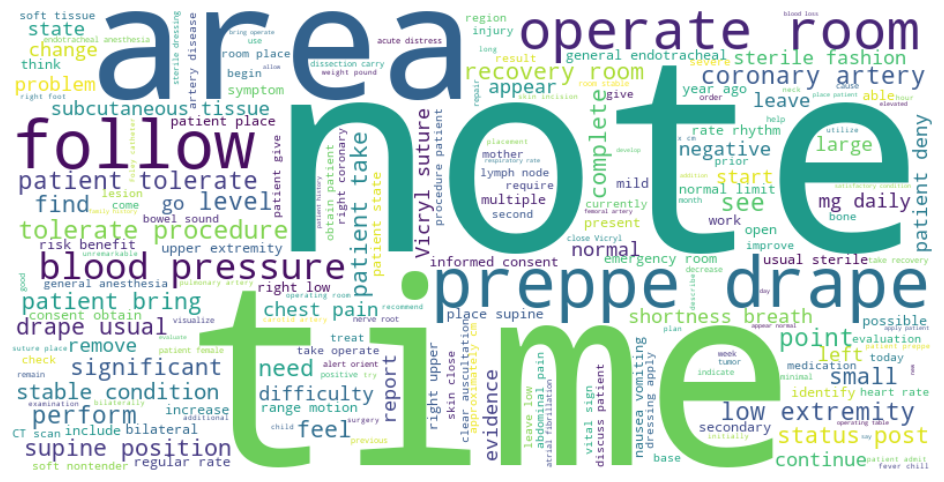

In [21]:
txt = " ".join(transcriptions_df['clean_text'])
create_word_cloud(txt, 'Most commonly used words and expressions of text (without stopwords)')

We can see that expressions such as "Note", "area" and "time" are commonly used. Words such as "tolerate procedure", "coronary artery" and "blood pressure" are also quite common.

### Medical specialties

First let's see what medical specialties are included in the dataset and what their distribution is 

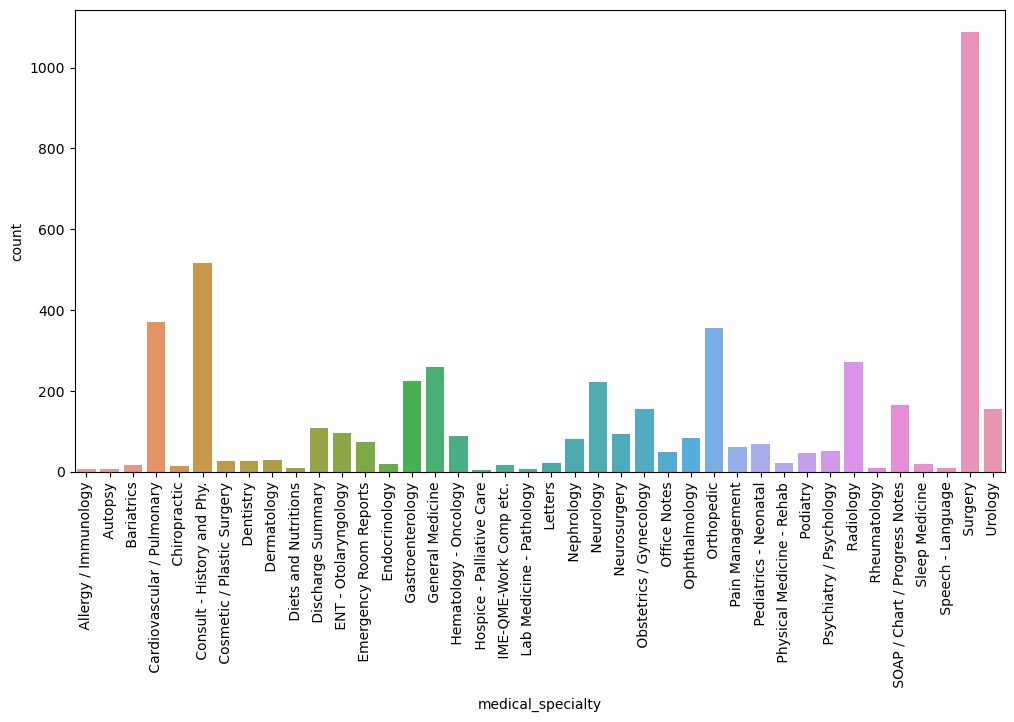

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(data=transcriptions_df, x="medical_specialty", ax=ax)
ax.tick_params(axis='x', labelrotation=90)
plt.show()



We can see that this dataset is imbalanced. "Surgery is about 1 out of 4 cases and specialties such as "Allergy/Immunology have just a handful of cases.

Let's use the whole dataset for the entity recognition and linking, and keep the most common specialties for classification later.


## 6. Named Entity Recognition (NER)

Now, we will perform NER on the text. 

- Extract diseases, medications, symptoms
- Visualize examples

The model (en_ner_bc5cdr_md) has been trained to recognise two entities - 'disease' and 'chemical', with F1 score 84% (https://allenai.github.io/scispacy/).

Let's first perform NER on one example and visualise the result. 

In [23]:
sample_doc = nlp(sample_txt)
displacy.render(sample_doc, style="ent", jupyter=True)

In this example, the model correctly recognises ureteropelvic junction obstruction as a 'disease'. We also see that 'IV antibiotics' is not recognised as a chemical compound, while the model extracted 'pain' as a disease, but ignored 'medications' which succeeds it. An alternative result would have been 'pain medication' recognised as 'chemical'.

In [24]:
print("TEXT", "ENTITY_TYPE")
for ent in sample_doc.ents:
    print(ent.text, ent.label_)

TEXT ENTITY_TYPE
ureteropelvic junction obstruction DISEASE
muscle caudate DISEASE
ureteropelvic junction obstruction DISEASE
fibrosis DISEASE
bowel injury DISEASE
ureteropelvic junction obstruction DISEASE
pain DISEASE


Now, let's extract entities from all transcriptions in the dataset. For each transcription, every entity will only be saved once, so there will be no dublicate disease or chemical in the same record.

In [25]:
def get_entities(txt):
    '''
    Uses scispacy model nlp (as defined above) to identify entities 
    and saves them in a defaultdict, to avoid duplication

    txt (str): the text from which we want to extract entities

    returns d (defaultdict)
    '''
    d = defaultdict()
    doc = nlp(txt)
    for ent in doc.ents:
        d[ent.text] = ent.label_
    return d

In [26]:
transcriptions_df['entities_dictionary'] = transcriptions_df.transcription.apply(get_entities)


In [27]:
transcriptions_df.iloc[sample_loc].entities_dictionary

defaultdict(None,
            {'ureteropelvic junction obstruction': 'DISEASE',
             'muscle caudate': 'DISEASE',
             'fibrosis': 'DISEASE',
             'bowel injury': 'DISEASE',
             'pain': 'DISEASE'})

Now, let's see the most common diseases and chemical compounds, as recognised by the model.

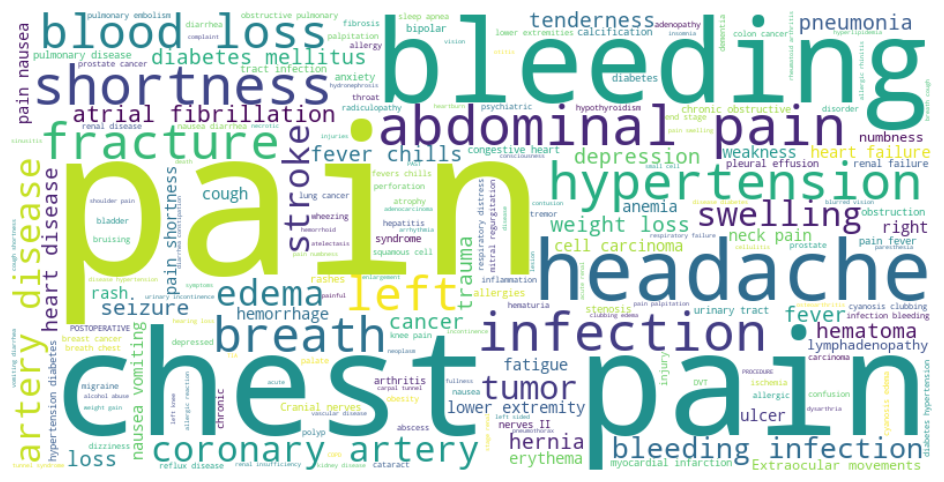

In [28]:
diseases = []
chemicals = []

def group_entities(d):
    '''
    Groups entities by type - specific to the 'CHEMICAL', 'DISEASE' entity types

    d (defaultdict): a dictionary that contains the key-value sets: entity_name:entity_type
    '''
    for e, l in zip(list(d.keys()), list(d.values())):
        if (l == "DISEASE"):
            diseases.append(e)
        elif (l == "CHEMICAL"):
            chemicals.append(e)
        else:
            pass
    return (diseases, chemicals)

groupred_entities = transcriptions_df.entities_dictionary.apply(group_entities)[0]

text = " ".join(groupred_entities[0])
create_word_cloud(text, 'Most common conditions')

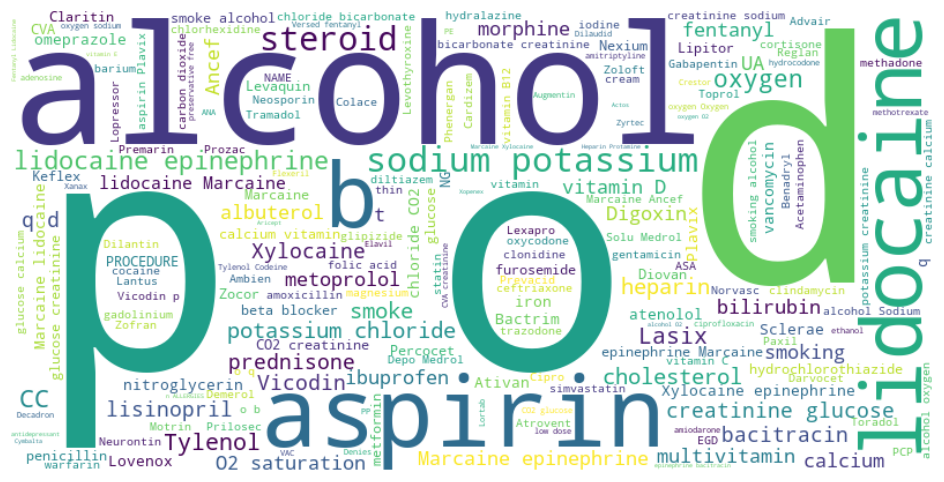

In [29]:
text = " ".join(groupred_entities[1])
create_word_cloud(text, 'Most common chemical compounds/medication')

The visualisations above show that common **conditions** are "pain" in general, as well as "chest pain" and "abdominal pain" in particular. "Headache", "coronary artery" and "artery disease" are also common. 

Common **chemicals** are alcohol, aspirin and lidocaine, but also "oxygen" is recognised as a chemical compound, which is true but might not be appropriate depending on the context. "p", "o" and "d" are alse commonly used.

## 7. Entity linking 

In the visualisation of most common diseases, we can see that both "blood loss" and "bleeding" are very commonly used. These two expressions/words mean the same thing, but they would be considered different for a machine learning model. This is something that occurs often in speech, and as a result, in clinical text. Another example would be "heart attack" and "myocardial infraction".

To address this, it is important to identify and standardize medical terms, which can be achieved by using medical terminology systems. Such systems are

- Unified Medical Language System (UMLS) [2], 
- Systematized Medical Nomenclature for Medicine–Clinical Terminology (SNOMED-CT) [3], and
- Medical Subject Headings (MeSH) [4].

These systems provide a comprehensive and standardized set of medical concepts, each uniquely identified by an alphanumeric code. 

For this project, I after identifying diseases and chemical compounds we can map them to the standardized terms available in UMLS. For this, I will use the EntityLinker component of sciSpaCy.

### A few words about UMLS and sciSpaCy's EntityLinker

For each entity, the EntityLoinker matches a mention to candidate concepts using string similarity and embeddings and returns a ranked list of (CUI , similarity_score) pairs. CUI (Concept Unique Identifier) is a concept to which different descriptions of a condition can be linked (ie. there are many ways to describe one single condition). For each entity, the EntityLinker also provides the similarity score for each related CUI. The linker also provides a definition of the concept described, as well as aliases and the Type Unique Identifier (TUI), which are used to organize and categorize the concepts within UMLS, linking related concepts together through their shared semantic type (eg. Diagnositic procedures, Disease or Syndrome).

### Example

First let's see what an entity linker does using one entity from our sample text. I will showcase the result using the linker to UMLS.

In [30]:
def add_component_pipe(component:str, config:dict={}, refresh=False):
    '''
    Add a component in the spaCy pipeline
    If the component is already present, but we want to add it, first remove it from the pipeline
    otherwise, do nothing
    But if the component is not already present in the pipeline, add it, based on the specifications 

    component:str    The component we want to add to the pipeline
    config: dict     The configuration specific to the component
    refresh: bool    Whether we want to add the component again (=True) or not (=False). Default is False
    '''
    if component in nlp.pipe_names:
        if refresh:
            nlp.remove_pipe(component)
        else:
            return
    nlp.add_pipe(component, config=config)


In [31]:
add_component_pipe(
    component="scispacy_linker", 
    config={"resolve_abbreviations": True, "linker_name": "umls"}
)

linker = nlp.get_pipe("scispacy_linker")


/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [32]:
def print_linked_entity(entity):
    print(f"Name: {entity.text} \n")
    # Each entity is linked to umls with a score
    if entity._.kb_ents:
        for i, link_ent in enumerate(entity._.kb_ents):
            print(f"RESULT NUMBER {i} \n")
            id, Score = link_ent
            print(f"Score = {Score} \n")
            print(f"id = {id} \n")
            print(f"{linker.kb.cui_to_entity[link_ent[0]]} \n")
    else: 
        print("No results for this entity")

In [33]:
doc = nlp(transcriptions_df.transcription[90])

entity = doc.ents[0]
print_linked_entity(entity)

Name: ureteropelvic junction obstruction 

RESULT NUMBER 0 

Score = 1.0 

id = C0521619 

CUI: C0521619, Name: Obstruction of pelviureteric junction
Definition: A usually congenital abnormality characterized by the partial obstruction of the junction between the renal pelvis and ureter. It may lead to hydronephrosis.
TUI(s): T190
Aliases (abbreviated, total: 13): 
	 PUJ - Pelviureteric obstruction, Ureteropelvic junction obstruction, Pelviureteric obstruction, Obstruction of pelviureteric junction (disorder), Ureteropelvic Junction Obstruction, Ureteropelvic junction stenosis, Pelviureteric junction obstruction, Pelvi-ureteric junction obstruction, PUO - Pelviureteric obstruction, Obstruction of pelviureteric junction 

RESULT NUMBER 1 

Score = 1.0 

id = C5574705 

CUI: C5574705, Name: CONGENITAL ANOMALIES OF KIDNEY AND URINARY TRACT 2
Definition: None
TUI(s): T047
Aliases: (total: 6): 
	 PELVIURETERIC JUNCTION OBSTRUCTION, CAKUT2, URETEROPELVIC JUNCTION OBSTRUCTION, UPJO, CONGENITA

In this case, "ureteropelvic junction obstruction" could be linked to five different concepts, and the ones scoring highest are

- CUI: C5574705, Name: CONGENITAL ANOMALIES OF KIDNEY AND URINARY TRACT 2
- CUI: C0521619, Name: Obstruction of pelviureteric junction


But it is possible that no match is found, as showcased in the example below.

In [34]:
entity = doc.ents[1]    

print_linked_entity(entity)

Name: muscle caudate 

No results for this entity


### Link all entities 

Now, let's link all entities in the data to the UMLS terminology. I will restrict the number of linked terms only to the first one (the one with the highest score).

In [35]:
def link_entity(text):
    linked_dict = {}
    entities = nlp(text).ents
    for entity in entities:
        if entity._.kb_ents:
            linked_dict[entity]=entity._.kb_ents[0][0]
    return linked_dict

In [36]:
# Update the EntityLinker to only return the first CUI in the list, which has the highest score
add_component_pipe(
    component="scispacy_linker", 
    config={"resolve_abbreviations": True, "linker_name": "umls", "max_entities_per_mention":1},
    refresh=True
)

transcriptions_df['linked_entities'] = transcriptions_df.transcription.apply(link_entity)
transcriptions_df.linked_entities[0]

{complaint of allergies: 'C0020517',
 allergies: 'C0020517',
 Claritin: 'C0701055',
 Zyrtec: 'C0162723',
 Tri-Cyclen: 'C0667848',
 Zyrtec: 'C0162723',
 loratadine: 'C0065180',
 Nasonex: 'C0594492'}

In [37]:
# Example of linked entities - get details
linked_ents = transcriptions_df.linked_entities[sample_loc]
linked_ents


{ureteropelvic junction obstruction: 'C0521619',
 ureteropelvic junction obstruction: 'C0521619',
 fibrosis: 'C0016059',
 bowel injury: 'C3263722',
 ureteropelvic junction obstruction: 'C0521619',
 pain: 'C0030193'}

In [38]:
transcriptions_df.shape

(4966, 7)

## 8. Classification – Medical specialties

### Feature engineering

At this point, we have extracted the entities from the transcription text and lined each entity to its best match in UMLS. The goal of this exercise is to train a classifier that predicts the medical specialty needed by a patient based on the transcript (complaints and medical history).

The dataset looks like this

In [39]:
transcriptions_copy = transcriptions_df.copy()
transcriptions_df.head(2)


,medical_specialty,transcription,length_medical_specialty,length_transcription,clean_text,entities_dictionary,linked_entities
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr...",21,1331,white female present complaint allergy allergy...,"{'complaint of allergies': 'DISEASE', 'allergi...","{(complaint, of, allergies): 'C0020517', (alle..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb...",11,2431,difficulty climb stair difficulty airline seat...,"{'pains': 'DISEASE', 'knee pain': 'DISEASE', '...","{(pains): 'C0030193', (knee, pain): 'C0231749'..."


The input to the classifier will be the CUIs extracted for each transcription (saved in column "linked_entities" and the output would be the column "medical_specialty". So next, I will discard the columns that are not relevant, use the index as transcript ID and create dummy variables of the CUIs.

In [40]:
transcriptions_df['CUI'] = transcriptions_df.linked_entities.apply(lambda x: list(set(x.values())))
transcriptions_df.head()

,medical_specialty,transcription,length_medical_specialty,length_transcription,clean_text,entities_dictionary,linked_entities,CUI
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr...",21,1331,white female present complaint allergy allergy...,"{'complaint of allergies': 'DISEASE', 'allergi...","{(complaint, of, allergies): 'C0020517', (alle...","[C0594492, C0065180, C0162723, C0701055, C0020..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb...",11,2431,difficulty climb stair difficulty airline seat...,"{'pains': 'DISEASE', 'knee pain': 'DISEASE', '...","{(pains): 'C0030193', (knee, pain): 'C0231749'...","[C0042025, C0231749, C0004238, C0700624, C0011..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",11,4422,see ABC today pleasant gentleman year old poun...,"{'weight loss': 'DISEASE', 'alcohol': 'CHEMICA...","{(weight, loss): 'C1262477', (weight, loss): '...","[C0042025, C0231749, C0004238, C0001962, C0011..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...",27,495,left atrial enlargement left atrial diameter n...,"{'Left atrial enlargement': 'DISEASE', 'pulmon...","{(Left, atrial, enlargement): 'C0238705', (pul...","[C0238705, C0034088]"
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,27,1618,left ventricular cavity size wall thickness ap...,{'left ventricular outflow tract gradient': 'D...,"{(left, ventricular, outflow, tract, gradient)...","[C1332344, C0003507, C4284103, C2973725, C1835..."


In [41]:
cols_to_keep = ['medical_specialty', 'CUI']
transcriptions_df = transcriptions_df[cols_to_keep]
transcriptions_df.insert(loc=0, column='transcript_id', value=transcriptions_df.index + 1)

transcriptions_df.head()


,transcript_id,medical_specialty,CUI
0,1,Allergy / Immunology,"[C0594492, C0065180, C0162723, C0701055, C0020..."
1,2,Bariatrics,"[C0042025, C0231749, C0004238, C0700624, C0011..."
2,3,Bariatrics,"[C0042025, C0231749, C0004238, C0001962, C0011..."
3,4,Cardiovascular / Pulmonary,"[C0238705, C0034088]"
4,5,Cardiovascular / Pulmonary,"[C1332344, C0003507, C4284103, C2973725, C1835..."


In [42]:
transcriptions_df = transcriptions_df.explode(column='CUI').reset_index(drop=True)

transcriptions_df.head()

,transcript_id,medical_specialty,CUI
0,1,Allergy / Immunology,C0594492
1,1,Allergy / Immunology,C0065180
2,1,Allergy / Immunology,C0162723
3,1,Allergy / Immunology,C0701055
4,1,Allergy / Immunology,C0020517


In [43]:
# Make a copy
trans_copy_df = transcriptions_df.copy()

In [44]:
# Create dummy variables of the CUI values

transcriptions_df = pd.get_dummies(
    transcriptions_df, columns=['CUI']
    )#.groupby('transcript_id').sum().reset_index()
transcriptions_df.head()

,transcript_id,medical_specialty,CUI_C0000294,CUI_C0000618,CUI_C0000726,CUI_C0000729,CUI_C0000731,CUI_C0000734,CUI_C0000737,CUI_C0000768,...,CUI_C5539411,CUI_C5539834,CUI_C5556563,CUI_C5566406,CUI_C5574708,CUI_C5574816,CUI_C5667487,CUI_C5667489,CUI_C5669509,CUI_C5690754
0,1,Allergy / Immunology,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Allergy / Immunology,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Allergy / Immunology,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,Allergy / Immunology,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,Allergy / Immunology,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
cui_cols = [c for c in transcriptions_df if c not in ['transcript_id', 'medical_specialty']]

agg_dict = {'medical_specialty': (lambda c: c.mode())}
agg_dict.update({col: 'sum' for col in cui_cols})

transcriptions_df = transcriptions_df.groupby('transcript_id').agg(agg_dict).reset_index()
transcriptions_df.head()

,transcript_id,medical_specialty,CUI_C0000294,CUI_C0000618,CUI_C0000726,CUI_C0000729,CUI_C0000731,CUI_C0000734,CUI_C0000737,CUI_C0000768,...,CUI_C5539411,CUI_C5539834,CUI_C5556563,CUI_C5566406,CUI_C5574708,CUI_C5574816,CUI_C5667487,CUI_C5667489,CUI_C5669509,CUI_C5690754
0,1,Allergy / Immunology,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Bariatrics,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Bariatrics,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Cardiovascular / Pulmonary,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Cardiovascular / Pulmonary,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
transcriptions_df.dtypes

transcript_id         int64
medical_specialty    object
CUI_C0000294          uint8
CUI_C0000618          uint8
CUI_C0000726          uint8
                      ...  
CUI_C5574816          uint8
CUI_C5667487          uint8
CUI_C5667489          uint8
CUI_C5669509          uint8
CUI_C5690754          uint8
Length: 3761, dtype: object

As mentioned earlier, the dataset contains over 20 medical specialties, and some of them are uncommon within the dataset. Additionally, the most common medical specialty ("Surgery") is almost 25% of the dataset, thus the dataset is very imbalanced, with more than half the categories having only a hanful of samples.

To deal with this, we will first only kee the top-5 medical specialties in the dataset.

In [47]:
num_specialties = 5

top_specialties = transcriptions_df.medical_specialty.value_counts()[:5].index

transcriptions_sub_df = transcriptions_df[transcriptions_df.medical_specialty.isin(top_specialties)].reset_index(drop=True)

# medical_specialty should be of 'category' type
transcriptions_sub_df.medical_specialty = transcriptions_sub_df.medical_specialty.astype("category")

In [48]:
# Remove the categories that are not in the dataset any more
transcriptions_sub_df.medical_specialty.cat.remove_unused_categories()
transcriptions_sub_df.head()

,transcript_id,medical_specialty,CUI_C0000294,CUI_C0000618,CUI_C0000726,CUI_C0000729,CUI_C0000731,CUI_C0000734,CUI_C0000737,CUI_C0000768,...,CUI_C5539411,CUI_C5539834,CUI_C5556563,CUI_C5566406,CUI_C5574708,CUI_C5574816,CUI_C5667487,CUI_C5667489,CUI_C5669509,CUI_C5690754
0,4,Cardiovascular / Pulmonary,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,Cardiovascular / Pulmonary,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,Cardiovascular / Pulmonary,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10,Cardiovascular / Pulmonary,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,Cardiovascular / Pulmonary,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


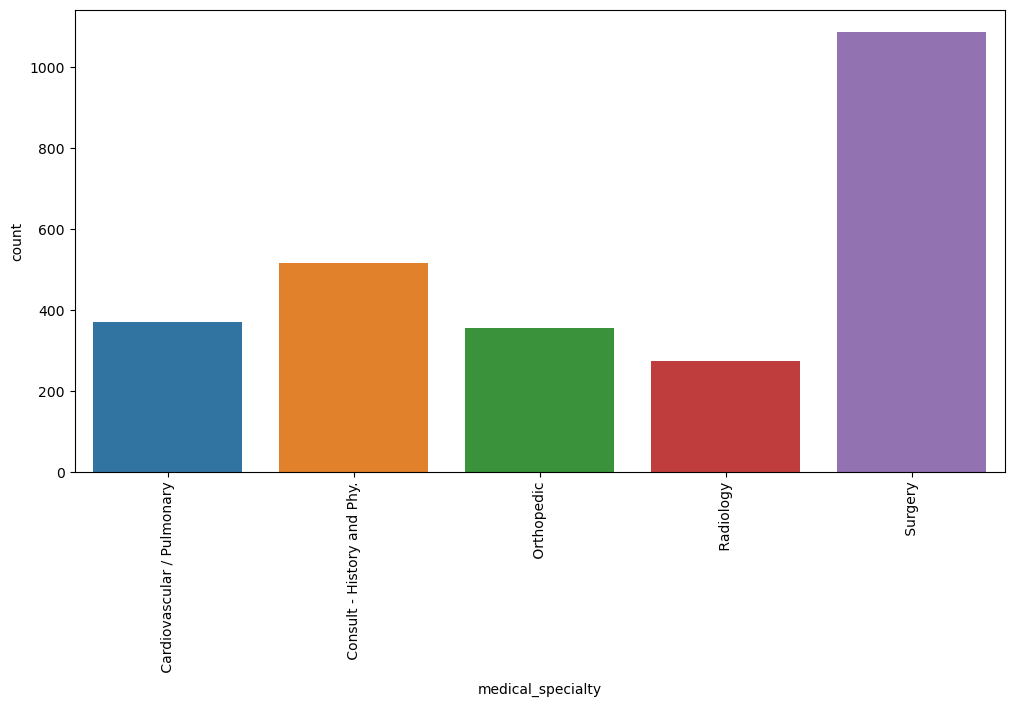

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(data=transcriptions_sub_df, x="medical_specialty", ax=ax)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

### Train-Test Split

In [50]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate

X = transcriptions_sub_df.drop(columns=['medical_specialty'])
y = transcriptions_sub_df.medical_specialty

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

### Baseline model

As a baseline model, we will use a very simple model that predicts the medical specialty of a sample randomly, based on the probability of each specialty in the training dataset. For this, I use the DumyClassifier class of scikit_learn

In [133]:
from sklearn.dummy import DummyClassifier

strategy = 'stratified'

baseline_cls = DummyClassifier(strategy=strategy)    
baseline_cls.fit(X_train, y_train)

y_pred = baseline_cls.predict(X_test)
cr = classification_report(y_test, y_pred, output_dict=True)
print(pd.DataFrame(cr))

f1_score_baseline = cr['weighted avg']['f1-score']


            Cardiovascular / Pulmonary   Consult - History and Phy.  \
precision                     0.129032                     0.172727   
recall                        0.162162                     0.184466   
f1-score                      0.143713                     0.178404   
support                      74.000000                   103.000000   

            Orthopedic   Radiology     Surgery  accuracy   macro avg  \
precision     0.119403    0.120000    0.388060  0.236084    0.185844   
recall        0.112676    0.109091    0.357798  0.236084    0.185239   
f1-score      0.115942    0.114286    0.372315  0.236084    0.184932   
support      71.000000   55.000000  218.000000  0.236084  521.000000   

           weighted avg  
precision      0.243789  
recall         0.236084  
f1-score       0.239333  
support      521.000000  


This classifier has really low accuracy, recall and f1 score. Next, let's train some advaced classifiers, to find the one that produces the best results for this use case.

### Train selected classification models

I will now train a few "traditional" ML models. Initially, the default parameters will be used for training in a 5-fold cross validation. From those models, I will senect the three best performing models (based on f1 score on the test set), and run them using cross-validation and a grid search for best parameters, in order to select the model with the best average f1 score.

In [130]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, f1_score

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)
scoring = ['precision_weighted', 'recall_weighted', 'f1_weighted']

classifier_names = [
    "LogisticRegression",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
]

classifiers = [
    LogisticRegression(class_weight="balanced"),
    SVC(kernel="linear",class_weight='balanced', random_state=0),
    SVC(random_state=0,class_weight='balanced'),
    DecisionTreeClassifier(class_weight='balanced', random_state=0),
    RandomForestClassifier(class_weight='balanced', random_state=0),
    AdaBoostClassifier(random_state=0),
    GaussianNB(),
]

CV_scores = {}

for classifier_name, classifier in zip(classifier_names, classifiers):
    print(f"Classifier: {classifier_name} \n")
    cv_score = cross_validate(
        classifier, X_train, y_train, cv=cv, scoring=scoring
    )
    CV_scores[classifier_name] = cv_score


Classifier: LogisticRegression 



/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

Classifier: Linear SVM 

Classifier: RBF SVM 

Classifier: Decision Tree 

Classifier: Random Forest 

Classifier: AdaBoost 



/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

Classifier: Naive Bayes 



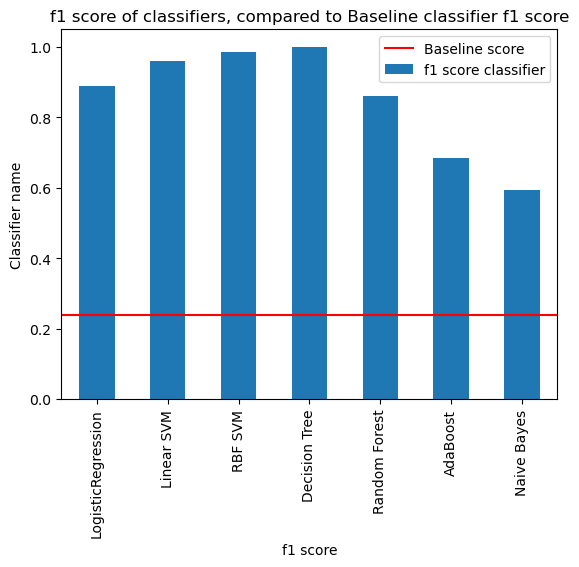

In [134]:
def get_score_df(score_dict, scores_list):
    d = {}
    for score in scores_list:
        if score in score_dict.keys():
            d[score] = score_dict[score].mean()
    return d

dd = {}
for m in CV_scores.keys(): 
    dd[m] = get_score_df(CV_scores[m], ['test_precision_weighted', 'test_recall_weighted', 'test_f1_weighted'])

df = pd.DataFrame(dd)

fig, ax = plt.subplots()
df.T.test_f1_weighted.plot.bar(label='f1 score classifier')
plt.axhline(y=f1_score_baseline, color='r', label='Baseline score')
plt.xlabel('f1 score')
plt.ylabel('Classifier name')
plt.title('f1 score of classifiers, compared to Baseline classifier f1 score')
plt.legend()
plt.show()

All classifiers perform better than the baseline. The best performing classifiers are Linear SVR, RBF SVR and Decision Tree.

### Hyperparameter tuning

Now, I will search for optimal hyperparameters using a grid of values of each of the top three performing classifiers above. The classifier with the highest 

In [135]:
from sklearn.model_selection import GridSearchCV

params_grid = {
    "Linear SVM": {
        'C': np.logspace(-1, 1, 7), 
        'kernel': ['linear'], 
        'gamma': ['scale', 'auto'], 
        'shrinking': [True, False], 
        'class_weight': ['balanced'],
        'random_state':[0]
    },
    "RBF SVM": {
        'C': np.logspace(-1, 1, 7), 
        'gamma': ['scale', 'auto'], 
        'shrinking': [True, False], 
        'class_weight': ['balanced'],
        'random_state':[0]
    },
    "Decision Tree": {
        'max_depth':[5,8,10,15,20],
        'min_samples_split': [2,4,6,8],
        'min_samples_leaf': [1,2,4],
        'max_features': [None, 'log2', 'sqrt'],
        'random_state':[0],
    },
}

hyperparameters_pickle_file = 'hyperparameters.pickle'
if os.path.exists(hyperparameters_pickle_file):
    with open('hyperparameters.pickle', 'rb') as handle:
    hparams = pickle.load(handle)

else:
    hparams = {}

    for classifier_name, classifier in zip(classifier_names, classifiers):
        if classifier_name in params_grid.keys():
            print(f'Classifier name: {classifier_name}')
            clf = GridSearchCV(estimator=classifier, param_grid=params_grid[classifier_name], cv=cv, scoring=scoring, refit='f1_weighted')
            clf.fit(X_train, y_train)
            hparams[classifier_name] = {'best_estimator': clf.best_estimator_,
                         'best_params': clf.best_params_,
                         'best_score': clf.best_score_}
    with open('hyperparameters.pickle', 'wb') as handle:
        pickle.dump(hparams, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

Classifier name: Linear SVM
Classifier name: RBF SVM
Classifier name: Decision Tree


/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mariakalimeri/opt/anaconda3/envs/nlp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [148]:
params_df = pd.DataFrame(hparams).T
params_df

,best_estimator,best_params,best_score
Linear SVM,"SVC(C=0.1, class_weight='balanced', kernel='li...","{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",0.967473
RBF SVM,"SVC(C=0.1, class_weight='balanced', gamma='aut...","{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",0.999521
Decision Tree,DecisionTreeClassifier(class_weight='balanced'...,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.999521


In [146]:
best_estimator = params_df[params_df.best_score==params_df.best_score.max()].best_estimator
best_estimator

RBF SVM          SVC(C=0.1, class_weight='balanced', gamma='aut...
Decision Tree    DecisionTreeClassifier(class_weight='balanced'...
Name: best_estimator, dtype: object

As we can see, RBF SVC and DecisionTree classifiers have the same score. I will perform cross validation again, to collect data for each fold. If the f1 score of one model appears to have lower variance among folds, it will be considered a more suitable model.

## 9. Conclusion & Insights


## 10. Resources

[1] https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions?resource=download

[2] Bodenreider O. (2004). The Unified Medical Language System (UMLS): integrating biomedical terminology. Nucleic acids research, 32(Database issue), D267–D270. https://doi.org/10.1093/nar/gkh061

[3] https://www.nlm.nih.gov/healthit/snomedct/index.html

[4] https://www.nlm.nih.gov/mesh/meshhome.html


**Interesting articles**

https://towardsdatascience.com/building-a-biomedical-entity-linker-with-llms-d385cb85c15a/
